<a href="https://colab.research.google.com/github/afnanrahman/EAFP/blob/OmerAndKevin/support_vector_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Support Vector Machine Classifier
## Kevin Qu, Omer Raza Khan
We chose to use this model because SVMs tend to work better with small sample sizes and with 1400 observations, may bring a strong accuracy


## Importing Packages and Data

In [ ]:
# Standard Packages
import pandas as pd
import numpy as np

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# SVM and Model Metrics
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support as score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve

# Feature Selection
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import SequentialFeatureSelector

# Standardization
from sklearn.preprocessing import StandardScaler

# Model Selection
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score


# Setting style of plots
sns.reset_orig()
sns.set_style("darkgrid")
sns.set(font_scale=1.2)

In [ ]:
data = pd.read_csv("https://raw.githubusercontent.com/afnanrahman/EAFP/main/data/clean_smote_data.csv")
data

,age,business_travel,daily_rate,department,distance_from_home,education,education_field,employee_number,environment_satisfaction,gender,hourly_rate,job_involvement,job_level,job_role,job_satisfaction,marital_status,monthly_rate,num_companies_worked,over_time,percent_salary_hike,performance_rating,relationship_satisfaction,stock_option_level,total_working_years,training_times_last_year,work_life_balance,years_at_company,years_in_current_role,years_with_curr_manager,attrition,rate_avg
0,41,2,1102,2,1,2,1,1,2,0,94,3,2,7,4,2,19479,8,1,11,3,1,0,8,0,1,6,4,5,1,6891.67
1,49,1,279,1,8,1,1,2,3,1,61,2,2,6,2,1,24907,1,0,23,4,4,1,10,3,3,10,7,7,0,8415.67
2,37,2,1373,1,2,2,4,4,4,1,92,2,1,2,3,2,2396,6,1,15,3,2,0,7,3,3,0,0,0,1,1287.00
3,33,1,1392,1,3,4,1,5,4,0,56,3,1,6,3,1,23159,1,1,11,3,3,0,8,3,3,8,7,0,0,8202.33
4,27,2,591,1,2,1,3,7,1,1,40,3,1,2,2,1,16632,9,0,12,3,4,1,6,3,3,2,2,2,0,5754.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2461,39,2,1053,1,7,2,2,1160,1,0,72,1,1,0,1,1,14504,4,0,13,3,1,0,12,2,2,1,0,0,1,5209.67
2462,32,0,453,1,11,2,3,998,3,1,43,2,1,4,1,1,10219,0,1,22,4,2,0,4,0,2,3,2,2,1,3571.67
2463,34,2,489,1,7,3,2,1729,3,1,59,2,2,4,1,1,5098,1,0,13,3,2,0,10,4,1,10,4,7,1,1882.00
2464,36,2,237,1,18,3,1,1080,1,0,49,2,1,5,2,1,11643,4,1,11,3,2,0,12,1,2,6,3,2,1,3976.33


## Base Model

In [ ]:
# Splitting data into training and testing sets
X = data.drop("attrition", axis=1)
Y = data['attrition']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

# Fitting onto model and scoring
clf = SVC(kernel='rbf')
clf.fit(X_train, Y_train)
clf.score(X_test, Y_test)

0.5121621621621621

So, using the base model with no prior preprocessing yields an accuracy of **51.2%**

## Manual Feature Selection

In this section, we categorize similar columns together and train on combinations of these groups to investigate the performance of our model. Here, we partition our columns into **4 groups**

### Grouping Columns
### Demographics
* age
* distance_from_home
* education
* education_field
* gender
* marital_status
* total_working_years

### Type of Job
* department
* job_involvement
* job_level
* job_role
* job_satisfaction
* training_times_last_year
* business_travel

### Financial Factors
* rate_avg
* percent_salary_hike
* stock_option_level
* over_time

### Life at Work
* years_with_curr_manager
* work_life_balance
* environment_satisfaction
* performance_rating

In [ ]:
# Code for grouping categories above, indexed by above order
cols = []
cols.append(['age', 'distance_from_home', 'education', 'education_field',
                    'gender', 'marital_status', 'total_working_years'])
cols.append(['department', 'job_involvement', 'job_level', 'job_role',
                 'job_satisfaction', 'training_times_last_year',
                 'business_travel'])
cols.append(['rate_avg', 'percent_salary_hike', 'stock_option_level',
                'over_time'])
cols.append(['years_with_curr_manager', 'work_life_balance',
                  'environment_satisfaction', 'performance_rating'])
demographicX = data[cols[0]]
Y = data['attrition']

### Base Accuracies Per Individual Group

In [ ]:
# Training on each subgroup, storing accuracy in scores[]
scores = []
for e in cols:
  X = data[e]
  Y = data['attrition']
  X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
  clf = SVC(kernel='rbf')
  clf.fit(X_train, Y_train)
  Y_pred = clf.predict(X_test)
  scores.append(clf.score(X_test, Y_test))
scores

[0.6662162162162162,
 0.7824324324324324,
 0.4851351351351351,
 0.7486486486486487]

**Demographic Group** yielded **66.6%** accuracy <br>
**Type of Job Group** yielded **78.2%** accuracy <br>
**Financial Factors** yielded **48.5%** accuracy <br>
**Life at Work Group** yielded **74.8%** accuracy <br>

### Base Accuracies Per Combinations of Groups

We then train on a combination of groups to see if our model performs better or worse than training on individual groups <br>
First, we define a function to create combinations and then train on each combination and compare accuracies

In [ ]:
# Function returns a set containing all subsets of *items* 
# Ex) combinations([0,1,2]) -> ([0],[1],[2],[0,1],[0,2],[0,1,2],[])
# Packages imported here are used in this cell only
from itertools import compress, product
from itertools import chain
def combinations(items):
    return (set(compress(items,mask)) for mask in product(*[[0,1]]*len(items)))

In [ ]:
# Defining dictionary mapping groups to respective columns
category_dict = {"demographics": cols[0],
                 "type": cols[1],
                 "financial": cols[2],
                 "life": cols[3]}

# Removing individual groups and empty set from combinations
combos = list(combinations(category_dict.keys()))
combos.remove(set())
for key in category_dict.keys():
  combos.remove({key})
combos

[{'financial', 'life'},
 {'life', 'type'},
 {'financial', 'type'},
 {'financial', 'life', 'type'},
 {'demographics', 'life'},
 {'demographics', 'financial'},
 {'demographics', 'financial', 'life'},
 {'demographics', 'type'},
 {'demographics', 'life', 'type'},
 {'demographics', 'financial', 'type'},
 {'demographics', 'financial', 'life', 'type'}]

In [ ]:
# TRAINING ON EACH COMBINATION
# Storing accuracies in scores[]
scores = []
for combo in combos:
  X = []
  for group in combo:
    X.append(category_dict[group])
  X = data[list(chain.from_iterable(X))]
  Y = data["attrition"]
  X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
  clf = SVC()
  clf.fit(X_train, Y_train)
  Y_pred = clf.predict(X_test)
  scores.append(clf.score(X_test, Y_test))
scores

[0.4797297297297297,
 0.8175675675675675,
 0.4797297297297297,
 0.4797297297297297,
 0.7405405405405405,
 0.4797297297297297,
 0.4797297297297297,
 0.7621621621621621,
 0.7986486486486486,
 0.4797297297297297,
 0.4797297297297297]

Combination of categories **Life at Work** and **Type of Job** yielded highest accuracy of about **81.7%**

### Accuracy on Top 15 and Removing Similar Columns

How does the accuracy for a combination of columns perform with regards to the **top 15 best predictors** of attrition? Let's take a sneak peak on how our model would perform before diving full force into automated feature selection

In [ ]:
# Manually removing similar columns (in terms of context)
remove = ['total_working_years', 'years_at_company', 'percent_salary_hike',
               'years_with_curr_manager', 'hourly_rate', 'daily_rate', 
               'monthly_rate']
no_attrition = data.drop('attrition', axis=1)
no_correlation = [e for e in list(no_attrition.columns) if e not in remove]
no_correlation

['age',
 'business_travel',
 'department',
 'distance_from_home',
 'education',
 'education_field',
 'employee_number',
 'environment_satisfaction',
 'gender',
 'job_involvement',
 'job_level',
 'job_role',
 'job_satisfaction',
 'marital_status',
 'num_companies_worked',
 'over_time',
 'performance_rating',
 'relationship_satisfaction',
 'stock_option_level',
 'training_times_last_year',
 'work_life_balance',
 'years_in_current_role',
 'rate_avg']

In [ ]:
# Splitting data into train test sets
X = data[no_correlation]
Y = data['attrition']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

# Selecting Top k features
select = SelectKBest(score_func=f_classif, k=15)
X_train_select = select.fit_transform(X_train, Y_train)

In [ ]:
# Scoring the features
X_train.columns.values[select.get_support()]
score_df = pd.DataFrame({'Feature': list(X_train), 'Scores': select.scores_})
score_df.sort_values(by='Scores', ascending=False)

,Feature,Scores
10,job_level,252.184784
9,job_involvement,219.524410
18,stock_option_level,203.400042
20,work_life_balance,142.300362
7,environment_satisfaction,139.702217
12,job_satisfaction,123.149892
19,training_times_last_year,121.555022
21,years_in_current_role,119.083473
0,age,105.315269
17,relationship_satisfaction,80.006391


In [ ]:
clf = SVC(kernel='rbf')
clf.fit(X_train_select, Y_train)
X_test_select = select.transform(X_test)
Y_pred = clf.predict(X_test_select)
accuracy_score(Y_test, Y_pred)

0.8067567567567567

It seems that using the filter method of **K=15** features and removing similar columns yields an accuracy of **80.68**

## Standardization of Data

After doing some research, we found that SVM's peformance can be improved when the predictors (or features of our data) are **normalized**. That is, when the data for each column converge to a Normal Distribution centered around a **mean of 0** and **unit variance**. Here, we comapare the results with a *linear* and *non-linear kernel*

In [ ]:
# Scaling data using StandardScalar module
sc = StandardScaler()
sc.fit(data[no_correlation])
data_scale = sc.transform(data[no_correlation])

### With Linear Kernel

In [ ]:
X = data_scale
Y = data['attrition']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
clf_linear = SVC(kernel='linear')
clf_linear.fit(X_train, Y_train)
clf_linear.score(X_test, Y_test)

0.8216216216216217

A **Scaled, Linear SVC** yields **82.1%** accuracy

### With Non-Linear Kernel

In [ ]:
X = data_scale
Y = data['attrition']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
clf = SVC(kernel='rbf')
clf.fit(X_train, Y_train)
clf.score(X_test, Y_test)

0.8756756756756757

A **Scaled, Non-Linear SVC** yields **87.5%** accuracy

Amazing! It seems the default non-linear kernel outperforms the linear kernel! We will continue using this model from here on out!

## Feature Selection - Wrapper Method

Now, we will use an automated way to select the top best features (predictors) of attrition using Wrappers. Here we use both the Forward and Backward Wrappers, however, both deliver the same results. <br>
**Note**: In both cases, we aim to find the **optimal number of features** as well as the features themselves to be trained on.

### Sequential Forward Selection Wrapper

In [ ]:
# Training on multiple number of columns, storing accuracy in scores{}
scores = {}
for n in range(1,23):
  clf_sfs = SVC()
  sfs = SequentialFeatureSelector(clf_sfs, n_features_to_select=n, direction="forward", scoring='accuracy')
  sfs = sfs.fit(X_train, Y_train)
  feat_cols = sfs.get_support(indices=True)
  clf_sfs.fit(X_train[:, feat_cols], Y_train)
  y_test_pred = clf_sfs.predict(X_test[:, feat_cols])
  scores[n] = accuracy_score(Y_test, y_test_pred)

In [ ]:
# Printing accuracies by {number of cols : accuracy} pairs
for key, value in scores.items():
    print(key, ' : ', value)

1  :  0.6675675675675675
2  :  0.7202702702702702
3  :  0.754054054054054
4  :  0.7905405405405406
5  :  0.8108108108108109
6  :  0.8337837837837838
7  :  0.822972972972973
8  :  0.8378378378378378
9  :  0.845945945945946
10  :  0.8378378378378378
11  :  0.8513513513513513
12  :  0.8567567567567568
13  :  0.8554054054054054
14  :  0.8662162162162163
15  :  0.8608108108108108
16  :  0.8689189189189189
17  :  0.8756756756756757
18  :  0.8864864864864865
19  :  0.8891891891891892
20  :  0.8824324324324324
21  :  0.8837837837837837
22  :  0.8797297297297297


In [ ]:
# What were the optimal features?
clf_sfs = SVC()
sfs = SequentialFeatureSelector(clf_sfs, n_features_to_select=19, direction="forward", scoring='accuracy')
sfs = sfs.fit(X_train, Y_train)
sfs.get_feature_names_out(no_correlation)

array(['age', 'business_travel', 'distance_from_home', 'education',
       'employee_number', 'environment_satisfaction', 'job_involvement',
       'job_level', 'job_role', 'job_satisfaction', 'marital_status',
       'over_time', 'performance_rating', 'relationship_satisfaction',
       'stock_option_level', 'training_times_last_year',
       'work_life_balance', 'years_in_current_role', 'rate_avg'],
      dtype=object)

In [ ]:
# Finding excluded columns
sfs.get_support(indices=True)

array([ 0,  1,  3,  4,  6,  7,  9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20,
       21, 22])

So, having around 18-21 features results in **88% accuracy**, with highest in having **19 features** with **88.9% accuracy**<br>
Excluded features: *gender, department, education_field, num_companies_worked*

### Sequential Backward Selection Wrapper

This section is commented out, as it performs the same as forward process and yields similar accuracies <br>
**Note**: Runtime is roughly 30 minutes for both selection processes

```
scores = {}
for n in range(15,23):
  clf_sfs = SVC()
  sfs = SequentialFeatureSelector(clf_sfs, n_features_to_select=n, direction="backward", scoring='accuracy')
  sfs = sfs.fit(X_train, Y_train)
  feat_cols = sfs.get_support(indices=True)
  clf_sfs.fit(X_train[:, feat_cols], Y_train)
  y_test_pred = clf_sfs.predict(X_test[:, feat_cols])
  scores[n] = accuracy_score(Y_test, y_test_pred)

# Printing accuracies by {number of cols : accuracy} pairs
for key, value in scores.items():
    print(key, ' : ', value)

# What were the optimal features?
clf_sfs = SVC()
sfs = SequentialFeatureSelector(clf_sfs, n_features_to_select=19, direction="forward", scoring='accuracy')
sfs = sfs.fit(X_train, Y_train)
print(sfs.get_feature_names_out(no_correlation))

# Finding excluded columns
print(sfs.get_support(indices=True))
```



## Hyperparameter Tuning

2 parameters of interest are **C** and **Gamma**

* **C** is a regularizer for the error term, tradeoff between smooth boundaries and 
classifying all training points correctly.
* **Gamma** is a parameter for non-linear kernals, like in our case, to determing the radius of the decision boundary around the clusters (groups).
<br>In both cases, the **higher** they are, the more likely they lead to **overfitting**

Now, we will be tuning the parameters of our model under Grid Search and then use Random Search to see if any better parameters exist. We will be comparing metrics to make a conclusion

### Grid Search Metrics

In [ ]:
# Defining parameter grid and intializing GridSearch
param_grid = {"C": [0.01, 0.1, 1, 10, 100],
              "gamma": [0.01, 0.1, 1, 10, 100]}
grid_cv = GridSearchCV(SVC(), param_grid, verbose=0)
grid_cv.fit(X_train, Y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'gamma': [0.01, 0.1, 1, 10, 100]})

In [ ]:
# What is the best estimator?
print(grid_cv.best_estimator_)

SVC(C=10, gamma=0.1)


              precision    recall  f1-score   support

           0       0.89      0.93      0.91       369
           1       0.93      0.89      0.91       371

    accuracy                           0.91       740
   macro avg       0.91      0.91      0.91       740
weighted avg       0.91      0.91      0.91       740



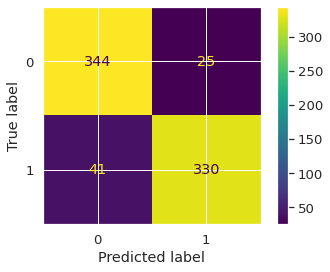

In [ ]:
# Visualizing the metrics of this model
grid_pred = grid_cv.predict(X_test)
cm = confusion_matrix(Y_test, grid_pred, labels=grid_cv.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid_cv.classes_)
disp.plot()

print(classification_report(Y_test, grid_pred))

So, setting **C = 10** and **gamma = 0.1** gives us the best Support Vector Classifier of attrition, with an **accuracy of 91%**, using *GridSearchCV*

### Random Search Metrics

In [ ]:
# Defining the parameter grid and initializing RandomizedSearch
param_grid = {"C": [x for x in range(11, 100, 10)],
              "gamma": [x/10 for x in range(1, 11)]}
rand_cv = RandomizedSearchCV(SVC(), param_grid, verbose=0)
rand_cv.fit(X_train, Y_train)

RandomizedSearchCV(estimator=SVC(),
                   param_distributions={'C': [11, 21, 31, 41, 51, 61, 71, 81,
                                              91],
                                        'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6,
                                                  0.7, 0.8, 0.9, 1.0]})

In [ ]:
# What is the best estimator?
print(rand_cv.best_estimator_)

SVC(C=71, gamma=0.1)


              precision    recall  f1-score   support

           0       0.89      0.93      0.91       369
           1       0.93      0.89      0.91       371

    accuracy                           0.91       740
   macro avg       0.91      0.91      0.91       740
weighted avg       0.91      0.91      0.91       740



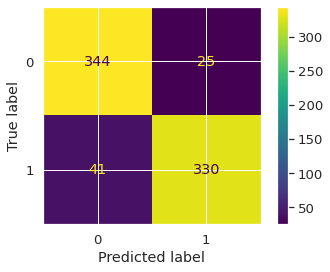

In [ ]:
# Visualizing the metrics of this model
rand_pred = rand_cv.predict(X_test)
print(classification_report(Y_test, rand_pred))
cm_rand = confusion_matrix(Y_test, rand_pred)
disp_rand_cm = ConfusionMatrixDisplay(confusion_matrix=cm_rand)
disp_rand_cm.plot()

So, it turns out using *randomized search* over the range of optimal values from *GridSearchCV* **does not** give us a better accuracy than 91%. Grid Search is more than enough for us.

## Final Model Metrics

After weeks of research, we have determined the best Support Vector Classifier of attrition to be one that is: <br> *Scaled, excluding 4 features, with C = 10 and Gamma = 0.1* using the default non-linear kernel. <br> Now, we will reveal the model metrics of our final model

### Accuracy, Precision, Recall, F1 Score

In [ ]:
# Working with the scaled data sets
X = pd.DataFrame(data_scale)
Y = pd.DataFrame(data["attrition"])
Y = np.ravel(Y)

In [ ]:
# Initializing KFolds and Classifier
kfold = KFold(n_splits=5, random_state=42, shuffle=True)
clf = SVC(C=10, gamma=0.1, kernel='rbf')

In [ ]:
# Computing metrics upon each fold for 5 folds
# Storing metrics in respective lists

clf_accuracies = []
clf_precisions = []
clf_recall = []
clf_f1_score = []

for train_index, test_index in kfold.split(X):
      X_train, X_test = X.iloc[train_index], X.iloc[test_index] 
      y_train, y_test = Y[train_index], Y[test_index]
      clf.fit(X_train, y_train)
      y_pred_clf = clf.predict(X_test)

      # evaluate predictions
      accuracy_clf = round(accuracy_score(y_test, y_pred_clf), 4) 
      clf_accuracies.append(round(accuracy_clf, 4))

      precision = precision_score(y_test, y_pred_clf)
      clf_precisions.append(round(precision,4))

      recall = recall_score(y_test, y_pred_clf)
      clf_recall.append(round(recall,4))

      f1 = f1_score(y_test, y_pred_clf)
      clf_f1_score.append(round(f1,4))

      
print("Accuracies:" , clf_accuracies )
print("Precisions:" , clf_precisions)
print("Recalls:", clf_recall)
print("F1_scores:" , clf_f1_score)

Accuracies: [0.9089, 0.931, 0.9128, 0.9249, 0.9087]
Precisions: [0.927, 0.9244, 0.938, 0.9061, 0.9323]
Recalls: [0.8852, 0.9322, 0.8902, 0.9407, 0.8931]
F1_scores: [0.9057, 0.9283, 0.9135, 0.9231, 0.9123]


In [ ]:
print("Accuracy: %.2f%%" % (np.mean(clf_accuracies)*100))
print("Precisions: %.2f%%" % (np.mean(clf_precisions)*100))
print("Recall: %.2f%%" % (np.mean(clf_recall)*100))
print("f1_score: %.2f%%" % (np.mean(clf_f1_score)*100))

Accuracy: 91.73%
Precisions: 92.56%
Recall: 90.83%
f1_score: 91.66%


It seems that are model is very precise and accurate, and doesn't misclassify new observations. This is a good indication that our model is not overfitting and does well with new observations. Now let's take a look at the AUC Score

### Reciever Operating Characteristic (ROC) Curve

AUC - Test Set: 90.98%


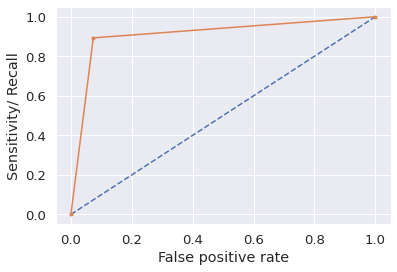

In [ ]:
auc = roc_auc_score(y_test, y_pred_clf)
print('AUC - Test Set: %.2f%%' % (auc*100))

# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_clf)

plt.plot([0, 1], [0, 1], linestyle='--')

# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False positive rate')
plt.ylabel('Sensitivity/ Recall')
# show the plot
plt.show()


Amazing! Our model is an amazing classifier for attrition with an **AUC of 90.98%**

## Conclusion

So, the best Support Vector Classifier has an accuracy of **91%**, with parameters **C = 10, Gamma = 0.1**, under *scaled data* and the default non-linear kernel. The model has similar precision and recall, which means our model generalizes well with new observations.